This notebook contains the production version of the BERT neural network for Sereniiti. It is not the production code for inference but the code that is used to train, test and improve the model.

# Training

## Parameters

In [41]:
# Dataset to use
dataset_path = '../data/sereniiti-dataset-0.0.2.csv'

# Max length of the sentences
max_length = 120

# Name of the BERT model to use
model_name = 'distilbert-base-uncased'

# Set the number of epochs for the training
epochs = 2

# Ratio of the data used for validation during training
validation_split=0.2

# Batch size for training
batch_size=64

# Adam optimizer paramaters
learning_rate=5e-05
epsilon=1e-08
decay=0.01
clipnorm=1.0

# Patience (nb of epochs) for early stopping
early_stopping_patience = 3

# Size of the hidden layers of the heads
# Y1 (steps)
nY11 = 512
nY12 = 125
# Y2 (tips)
nY21 = 512
nY22 = 256
# Y3 (rating)
nY31 = 512
nY32 = 125

# Save directory
savedir = '../saved_models/distilBERT/prod'

# Disable the GPU if un-commented
# To be used for GPUs with insufficient memory
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Installs and imports

In [42]:
#!pip install -q -U bert-tensorflow
#!pip install -q -U tensorflow-text
#!pip install -q -U tf-models-official
#!pip install -q -U transformers
#!pip install -q -U tensorflowjs

In [4]:
# Base libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Huggingface transformers
from transformers import DistilBertConfig,  DistilBertTokenizer, TFDistilBertModel

# Tensorflow
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

# tensorflow.keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

In [5]:
# Check if the GPU is enabled
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


## Open the dataset

In [45]:
# Prepare a list to drop columns with no use
cols = list(pd.read_csv(dataset_path, nrows=1))
drop_cols = ["id","Unnamed: 0","fr","tips","tips_groups","steps"]
drop_prefix = "tip_"
usecols = [i for i in cols if (i not in drop_cols) and not (i.startswith(drop_prefix))]

# Read the csv and drop na values
df = pd.read_csv(dataset_path, usecols=usecols).dropna()

# Correct the type issue on fivefold
df.fivefold = df.fivefold.astype(int)

# print the dataframe
df.describe()

,rating,fivefold,step_facts,step_emotions,step_needs,step_proposals,group_empathy,group_negative,group_feeling,group_fault,...,group_realistic,group_precise,group_unprecise,group_unrealistic,group_provocation,group_positivebias,group_judgemental,group_demanding,group_fact,group_positive
count,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,...,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000
mean,2.559149,2.983872,0.819849,0.212583,0.033141,0.191050,0.158175,0.027381,0.188658,0.207355,...,0.073195,0.023039,0.054763,0.002836,0.093221,0.048294,0.361187,0.006292,0.191405,0.048383
std,1.694178,1.407400,0.384330,0.409153,0.179013,0.393146,0.364921,0.163200,0.391254,0.405430,...,0.260467,0.150035,0.227527,0.053177,0.290755,0.214397,0.480366,0.079073,0.393424,0.214583
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Extract the variables

In [46]:
def train_test_split(df,columns=None,test_fold=5):
    """
    This function take a dataframe (slice) and cut it between the train and test set.
    """
    col = columns or df.drop(columns = "fivefold").columns
    df_full = df.drop(columns = "fivefold").loc[:,col]
    df_train = df.loc[df["fivefold"] != test_fold,:].drop(columns = "fivefold").loc[:,col]
    df_test  = df.loc[df["fivefold"] == test_fold,:].drop(columns = "fivefold").loc[:,col]
    return df_full, df_train, df_test

def cols_prefixed(df,prefix):
    return [col for col in df if col.startswith(prefix)]

In [47]:
# X
text, text_train, text_test = train_test_split(df,columns="en")

# Y1
step_cols = cols_prefixed(df,"step_")
step, step_train, step_test = train_test_split(df,columns=step_cols)

# Y2
group_cols = cols_prefixed(df,"group_")
group, group_train, group_test = train_test_split(df,columns=group_cols)

# Y3
df["scaled_rating"] = df["rating"]/5
rating, rating_train, rating_test = train_test_split(df,columns="scaled_rating")

In [48]:
# Steps and groups are already one hot encoded. We just need to extract the numpy arrays

# Step
Y1 = tf.convert_to_tensor(step_train.values, dtype=tf.float32)
# Group
Y2 = tf.convert_to_tensor(group_train.values, dtype=tf.float32)
# Rating
Y3 = tf.convert_to_tensor(rating_train.values, dtype=tf.float32)

print("Shape of Y1:", np.shape(Y1))
print("Shape of Y2:", np.shape(Y2))
print("Shape of Y3:", np.shape(Y3))

Shape of Y1: (9108, 4)
Shape of Y2: (9108, 16)
Shape of Y3: (9108,)


## Load the BERT model

In [49]:
# Load transformers config and set output_hidden_states to False
config = DistilBertConfig.from_pretrained(model_name)
config.output_hidden_states = False

config

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.11.3",
  "vocab_size": 30522
}

In [50]:
# Load BERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

tokenizer

PreTrainedTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [51]:
# Load the Transformers BERT model
encoder = TFDistilBertModel.from_pretrained(model_name, config = config)

encoder

ResourceExhaustedError: OOM when allocating tensor with shape[30522,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:TruncatedNormal]

## Tokenize the text

In [ ]:
# Tokenize the input (takes some time)
X = tokenizer(
    text=text_train.to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)

X

{'input_ids': <tf.Tensor: shape=(9108, 120), dtype=int32, numpy=
array([[  101,  3438,  1010, ...,     0,     0,     0],
       [  101,  1037,  2502, ...,     0,     0,     0],
       [  101,  1037, 18178, ...,     0,     0,     0],
       ...,
       [  101,  2052,  2017, ...,     0,     0,     0],
       [  101,  1045,  2514, ...,     0,     0,     0],
       [  101,  2169,  2051, ...,     0,     0,     0]])>, 'token_type_ids': <tf.Tensor: shape=(9108, 120), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(9108, 120), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}

## Create the model

In [ ]:
# Create model function
def create_model():

    # Build your model input
    input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
    attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32')
    
    inputs = {
        'input_ids': input_ids, 
        'attention_mask': attention_mask
        }
    
    # BERT, loading the model
    bert_model = encoder.distilbert(input_ids=input_ids, attention_mask=attention_mask)

    # Make sure BERT weights stay the same during training
    bert_model.trainable = False

    # Get the last hiddent state as an imput for the next layer
    bert_output = bert_model[0]
    print(bert_output)

    # DistilBERT output the sentence embedding on the [CLS] token at index 0 of each sentence
    embedding = bert_output[:, 0, :]

    # Then build the model output
    # Since we are not yet very sure of the coherence of the labels we use totally independent heads
    # Since one sentence can have several labels, we use sigmoid instead of softmax

    # Y1 (steps)
    Y1_layer1 = Dense(nY11, name='Y1_layer1')(embedding)
    Y1_layer2 = Dense(nY12, name='Y1_layer2')(Y1_layer1)
    Y1_output = Dense(units=Y1.shape[1], activation='sigmoid', name='Y1')(Y1_layer2)

    # Y2 (tips)
    Y2_layer1 = Dense(nY21, name='Y2_layer1')(embedding)
    Y2_layer2 = Dense(nY22, name='Y2_layer2')(Y2_layer1)
    Y2_output = Dense(units=Y2.shape[1], activation='sigmoid', name='Y2')(Y2_layer2)

    # Y3 (rating)
    Y3_layer1 = Dense(nY31, name='Y3_layer1')(embedding)
    Y3_layer2 = Dense(nY32, name='Y3_layer2')(Y3_layer1)
    Y3_output = Dense(1, name='Y3')(Y3_layer2)

    # Final outputs
    outputs = {'Y1': Y1_output, 'Y2': Y2_output, 'Y3': Y3_output}

    # Define the model
    model = Model(inputs=inputs, outputs=outputs, name='BERT_Sereniiti')

    # Set an optimizer
    optimizer = Adam(
        learning_rate=learning_rate,
        epsilon=epsilon,
        decay=decay,
        clipnorm=clipnorm)

    # Set loss functions
    loss = {
        'Y1': CategoricalCrossentropy(from_logits = False), 
        'Y2': CategoricalCrossentropy(from_logits = False),
        'Y3': tf.keras.losses.MeanSquaredError()
        }

    # Set metrics    
    metric = {
        'Y1': CategoricalAccuracy('accuracy'),
        'Y2': CategoricalAccuracy('accuracy'),
        'Y3': tf.keras.metrics.MeanSquaredError('mse')
        }

    # Compile the model
    model.compile(
        optimizer = optimizer,
        loss = loss, 
        metrics = metric)

    return model


# Create 
model = create_model()
    
# Take a look at the model
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 120, 768), dtype=tf.float32, name=None), name='distilbert/transformer/layer_._5/output_layer_norm/batchnorm/add_1:0', description="created by layer 'distilbert'")
Model: "BERT_Sereniiti"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 120)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
distilbert (TFDistilBertMainLay TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 attention

## Train the model

In [ ]:
def print_dimensions(dic):
    """Print the dimensions of the tensors in a dict"""
    for i in dic.items():
        print(i[0], i[1].shape)

In [ ]:
# Training input
x = {'input_ids': X['input_ids'], 'attention_mask': X['attention_mask']}

print_dimensions(x)

input_ids (9108, 120)
attention_mask (9108, 120)


In [ ]:
# Training output
y = {'Y1': Y1, 'Y2': Y2, 'Y3': Y3}

print_dimensions(y)

Y1 (9108, 4)
Y2 (9108, 16)
Y3 (9108,)


In [ ]:
# This callback will stop the training when there is no improvement in the loss for three consecutive epochs.
early_stopping_callback = EarlyStopping(monitor='loss', patience=early_stopping_patience)


In [ ]:
# Training phase

history = model.fit(
    x=x,
    y=y,
    validation_split=validation_split,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping_callback]
    )

Epoch 1/5
114/114 [==============================] - 1850s 16s/step - loss: 5.3552 - Y1_loss: 1.5268 - Y2_loss: 3.6449 - Y3_loss: 0.1836 - Y1_accuracy: 0.8096 - Y2_accuracy: 0.4846 - Y3_mse: 0.1836 - val_loss: 5.4242 - val_Y1_loss: 0.9002 - val_Y2_loss: 4.4825 - val_Y3_loss: 0.0414 - val_Y1_accuracy: 0.9621 - val_Y2_accuracy: 0.3178 - val_Y3_mse: 0.0414
Epoch 2/5
114/114 [==============================] - 1976s 17s/step - loss: 6.1207 - Y1_loss: 1.8752 - Y2_loss: 4.1779 - Y3_loss: 0.0676 - Y1_accuracy: 0.8412 - Y2_accuracy: 0.5667 - Y3_mse: 0.0676 - val_loss: 6.7996 - val_Y1_loss: 1.0671 - val_Y2_loss: 5.6843 - val_Y3_loss: 0.0482 - val_Y1_accuracy: 0.9424 - val_Y2_accuracy: 0.3425 - val_Y3_mse: 0.0482
Epoch 3/5
114/114 [==============================] - 1709s 15s/step - loss: 7.9144 - Y1_loss: 2.4631 - Y2_loss: 5.3972 - Y3_loss: 0.0541 - Y1_accuracy: 0.8648 - Y2_accuracy: 0.5906 - Y3_mse: 0.0541 - val_loss: 8.3390 - val_Y1_loss: 1.3490 - val_Y2_loss: 6.9406 - val_Y3_loss: 0.0495 - val

## Plot

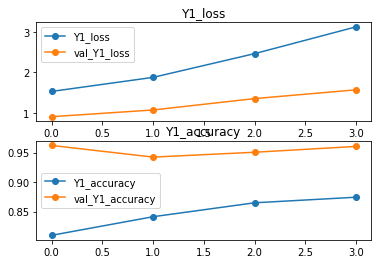

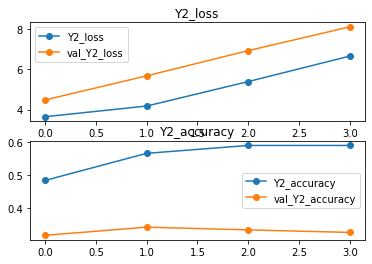

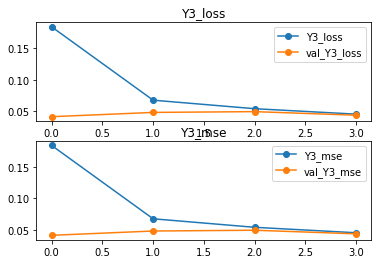

In [ ]:
def plot_history(loss,metric):
    """
    Plot the loss and metric with the provided names, contained in the history
    """

    # plot loss during training
    plt.subplot(211)
    plt.title(loss)
    plt.plot(history.history[loss], label=loss, marker='o')
    plt.plot(history.history[f'val_{loss}'], label=f'val_{loss}', marker='o')
    plt.legend()

    # plot accuracy during training
    plt.subplot(212)
    plt.title(metric)
    plt.plot(history.history[metric], label=metric, marker='o')
    plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}', marker='o')
    plt.legend()
    plt.show()


plot_history('Y1_loss','Y1_accuracy')
plot_history('Y2_loss','Y2_accuracy')
plot_history('Y3_loss','Y3_mse')

# Testing

## Prepare the test data

In [ ]:
# steps and groups are already one hot encoded
# We just need to extract the numpy arrays
Y1_test = step_test.values
Y2_test = group_test.values
Y3_test = rating_test.values

In [ ]:
# Output
y_test={'Y1': Y1_test, 'Y2': Y2_test, 'Y3': Y3_test}

print_dimensions(y_test)

Y1 (2177, 4)
Y2 (2177, 16)
Y3 (2177,)


## Tokenize

In [ ]:
# Test sentences
X_test = tokenizer(
    text=text_test.to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)

x_test={'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}

print_dimensions(x_test)

input_ids (2177, 120)
attention_mask (2177, 120)


## Evalutate

In [ ]:
# Run evaluation
model_eval = model.evaluate(
    x=x_test,
    y=y_test
)

69/69 [==============================] - 149s 2s/step - loss: 10.4034 - Y1_loss: 3.0581 - Y2_loss: 7.3093 - Y3_loss: 0.0361 - Y1_accuracy: 0.8659 - Y2_accuracy: 0.5145 - Y3_mse: 0.0361


In [ ]:
print("Y1_accuracy (step):",round(model_eval[-3],2))
print("Y2_accuracy (group):",round(model_eval[-2],2))
print("Y3_mse (rating):",round(model_eval[-1],3))

Y1_accuracy (step): 0.87
Y2_accuracy (group): 0.51
Y3_mse (rating): 0.036


In [ ]:
# Test it on a sentence

sentence = "I love chocolate"

embedded_sentence = tokenizer(
    text=sentence,
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)

print(embedded_sentence)

#model.predict(embedded_sentence)

{'input_ids': <tf.Tensor: shape=(1, 120), dtype=int32, numpy=
array([[ 101, 1045, 2293, 7967,  102,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>, 'token_type_ids': <tf.Tensor: shape=(1, 120), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

# Save the model

In [ ]:
# Save the entire model as a SavedModel.
savedir = savedir
model.save(savedir)

INFO:tensorflow:Assets written to: ../saved_models/distilBERT/latest\assets


INFO:tensorflow:Assets written to: ../saved_models/distilBERT/latest\assets
C:\Users\thiba\anaconda3\envs\bert\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


# Test the saved model for inference

In [ ]:
# Load the model from disk
new_model = tf.keras.models.load_model(savedir)

# Check its architecture
new_model.summary()

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Identity: Dst tensor is not initialized. [Op:Identity]

In [ ]:
# Evaluate the restored model to check if it works the same way as the original
model_eval = new_model.evaluate(
    x=x_test,
    y=y_test,
    verbose=2
)

69/69 - 169s - loss: 9.8764 - Y1_loss: 2.9466 - Y2_loss: 6.8779 - Y3_loss: 0.0519 - Y1_accuracy: 0.9012 - Y2_accuracy: 0.5498 - Y3_mse: 0.0519
